## 부스팅 방법

부스트(boost) 방법은 미리 정해진 갯수의 모형 집합을 사용하는 것이 아니라 하나의 모형에서 시작하여 모형 집합에 포함할 개별 모형을 하나씩 추가한다. 모형의 집합은 __위원회(commitee)__   C 라고 하고  m 개의 모형을 포함하는 위원회를  Cm 으로 표시한다. 위원회에 들어가는 개별 모형을 약 분류기(weak classifier)라고 하며  k 로 표시한다.

부스트 방법의 특징은 한번에 하나씩 모형을 추가한다는 것이다.

## 에이다부스트

에이다부스트(adaboost)라는 이름은 적응 부스트(adaptive boost)라는 용어에서 나왔다.
에이다부스트는 위원회에 넣을 개별 모형 $k_m$ 을 선별하는 방법으로는 학습 데이터 집합의 $i$번째 데이터에 가중치 $w_i$를 주고 분류 모형이 틀리게 예측한 데이터의 가중치를 합한 값을 손실함수 $L$로 사용한다. 이 손실함수를 최소화하는 모형이 $k_m$으로 선택된다.

$L_m = \sum_{i=1}^N w_{m,i} I\left(k_m(x_i) \neq y_i\right)$

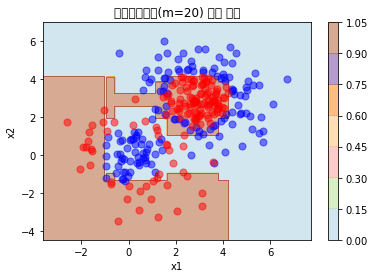

In [2]:
import warnings
 
warnings.filterwarnings("ignore")
import matplotlib as mpl
import seaborn as sns
import scipy as sp
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

class MyAdaBoostClassifier(AdaBoostClassifier):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        super(MyAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)
        self.sample_weight = [None] * n_estimators
        
    def _boost(self, iboost, X, y, sample_weight, random_state):
        sample_weight, estimator_weight, estimator_error = \
        super(MyAdaBoostClassifier, self)._boost(iboost, X, y, sample_weight, random_state)
        self.sample_weight[iboost] = sample_weight.copy()
        return sample_weight, estimator_weight, estimator_error
    
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=20)
model_ada.fit(X, y)

def plot_result(model, title="분류결과", legend=False, s=50):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    if isinstance(model, list):
        Y = model[0].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
        for i in range(len(model) - 1):
            Y += model[i + 1].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    else:
        Y = model.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=plt.cm.Paired, alpha=0.5)
    for i, n, c in zip(range(2), "01", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, s=s, alpha=0.5, label="Class %s" % n)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.colorbar(cs)
    if legend:
        plt.legend()
    plt.grid(False)

plot_result(model_ada, "에이다부스트(m=20) 분류 결과")

ValueError: s must be a scalar, or the same size as x and y

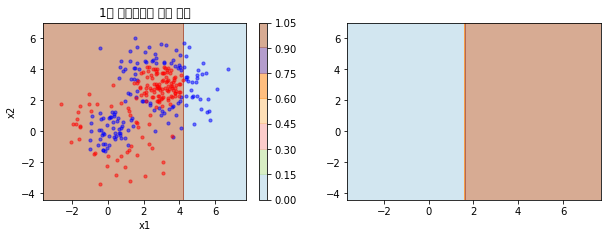

In [5]:
plt.figure(figsize=(10, 15))
plt.subplot(421); 
plot_result(model_ada.estimators_[0], "1번 분류모형의 분류 결과", s=10)
plt.subplot(422); 
plot_result(model_ada.estimators_[1], "2번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[0]).astype(int))
plt.subplot(423); 
plot_result(model_ada.estimators_[2], "3번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[1]).astype(int))
plt.subplot(424); 
plot_result(model_ada.estimators_[3], "4번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[2]).astype(int))
plt.subplot(425); 
plot_result(model_ada.estimators_[4], "5번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[3]).astype(int))
plt.subplot(426); 
plot_result(model_ada.estimators_[5], "6번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[4]).astype(int))
plt.subplot(427); 
plot_result(model_ada.estimators_[6], "7번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[5]).astype(int))
plt.subplot(428); 
plot_result(model_ada.estimators_[7], "8번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[6]).astype(int))
plt.tight_layout()

#### 에이다부스트 모형의 정규화

에이다부스트 모형이 과최적화가 되는 경우에는 학습 속도(learning rate) 조정하여 저유화를 할 수 있다. 이는 필요한 멤버의 수를 강제로 증가시켜서 과최적화를 막는 역할을 한다.

$C_m = C_{m-1} + \mu \alpha_m k_m$



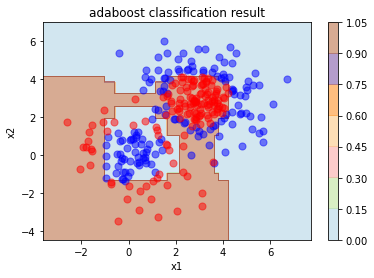

In [7]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0),
                          n_estimators=200, learning_rate=0.1).fit(X,y)

plot_result(model, 'adaboost classification result')

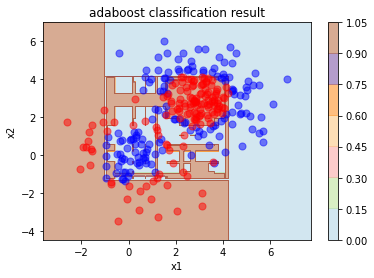

In [8]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0),
                          n_estimators=200).fit(X,y)

plot_result(model, 'adaboost classification result')

## 그레디언트 부스트

그레디언트 부스트 모형은 변분법(calculus of variations)을 사용한 모형이다.

함수$f(x)$를 최소화하는 x는 다음과 같이 gradient descent 방법으로 찾을 수 있다.
$x_{m} = x_{m-1} - \alpha_m \dfrac{df}{dx}$

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

In [10]:
%%time
model_grad.fit(X,y)

Wall time: 54.9 ms


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

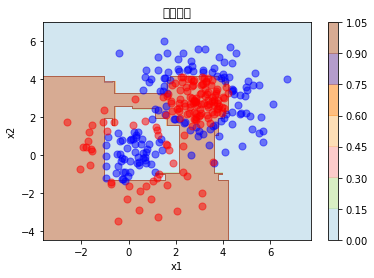

In [11]:
plot_result(model_grad)

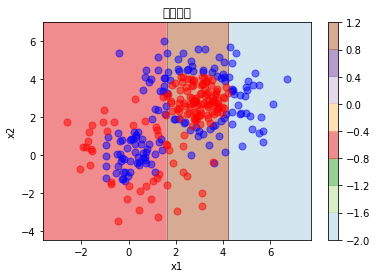

In [12]:
plot_result(model_grad.estimators_[0][0])

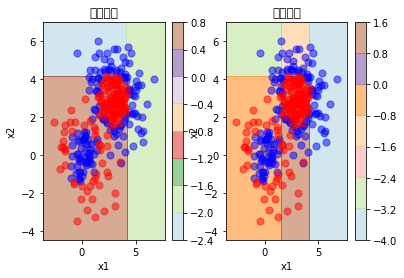

In [13]:
plt.subplot(121)
plot_result(model_grad.estimators_[1][0])
plt.subplot(122)
plot_result([model_grad.estimators_[0][0], model_grad.estimators_[1][0]])

In [15]:
import xgboost

ModuleNotFoundError: No module named 'xgboost'

In [16]:
!pip install xgboost

In [17]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimatros=100, max_depth=1, random_state=0)


In [18]:
%%time
model_xgb.fit(X,y)

[10:20:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimatros } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 26.9 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_estimatros=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

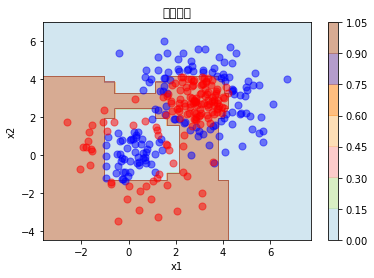

In [19]:
plot_result(model_xgb)

In [22]:
import lightgbm

model_lgbm = lightgbm.LGBMClassifier(n_estimators=100, max_depth=1, random_state=0)

In [21]:
!pip install lightgbm

  Using cached lightgbm-2.3.1-py2.py3-none-win_amd64.whl (544 kB)


In [23]:
%%time

model_lgbm.fit(X,y)

Wall time: 16.9 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

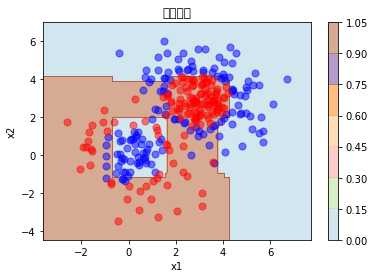

In [24]:
plot_result(model_lgbm)